In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'C:\Users\WIN8\Downloads\attribution_data.csv')

In [3]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [4]:
df.shape

(586737, 6)

In [5]:
df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [6]:
df['visit_order'].head()

586736    1
586734    1
586735    2
586731    1
586732    2
Name: visit_order, dtype: int64

Next, we’ll want to format the data frame from long-form to wide-form, so we’ll ultimately end up with a data frame containing a single row per user and the total chronological user-journey in a list of touch-points.
We’ll do this by first grouping the chronological touch-points into a list, merging the list of final conversion/non-conversion events onto that data frame and finally adding a “Null” or “Conversion” event to the end of our user-journey lists.

In [7]:
# Aggregating the channels for each cookie
df_paths = df.groupby('cookie')['channel'].aggregate(lambda x: x.unique().tolist()).reset_index()

# Mapping the last channel conversion 
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

# Creating a channel list for each cookie
paths_list = []
for channel in range(len(df_paths)):
    paths_list.append(df_paths.channel)

# Creating a channel-conversion column
paths = []
s = ['Start']
n = ['Null']
c = ['Conversion']

for i in range(len(df_paths)):
    if df_paths.iloc[i].conversion == 0:
        paths.append(s+paths_list[0][i]+n)
    else:
        paths.append(s+paths_list[0][i]+c)
        
df_paths['paths'] = paths
df_paths = df_paths[['cookie', 'paths']]

In [8]:
df_paths.head()

,cookie,paths
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,"[Start, Paid Search, Null]"


## Markov Chains

The algorithm for Markov Chains can be summarized in 2 steps:

Calculate transition probabilities between all states in our state-space

Calculate removal effects

We’ll start by defining a list of all user journeys, the number of total conversion and the base level conversion rate. All things we’ll make use of later:

In [9]:
list_of_paths = df_paths['paths']
total_conversions = sum(path.count('Conversion') for path in df_paths['paths'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

Next, we’ll define a function that identifies all potential state transitions and outputs a dictionary containing these. We’ll use this as an input when calculating transition probabilities:

In [11]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

And the function to calculate all transition probabilities can be defined as:

In [12]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        # Extracting the index number for unique channels in each row of dictionary
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            # Computing the sum of conversions for each unique channel
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            # Computing transition probabilities        
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

The above should leave us with a dictionary containing all transitions and their respective transition probabilities given our historical data.
The final step is then to identify removal effects for each of our marketing channels. To do this we’ll make use of linear algebra and matrix manipulations, therefore let’s turn our above transition probabilities dictionary into a data frame (matrix):

In [13]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    
    # Creating a null matrix of channels
    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0
    
    # Assigning the transition probabilites to the trans_matrix 
    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

The transition matrix we just produced actually holds a great deal of valuable information on its own. An immediate derivative of it would be to generate a directional graph or transition heat map to visualize the typical user journeys.


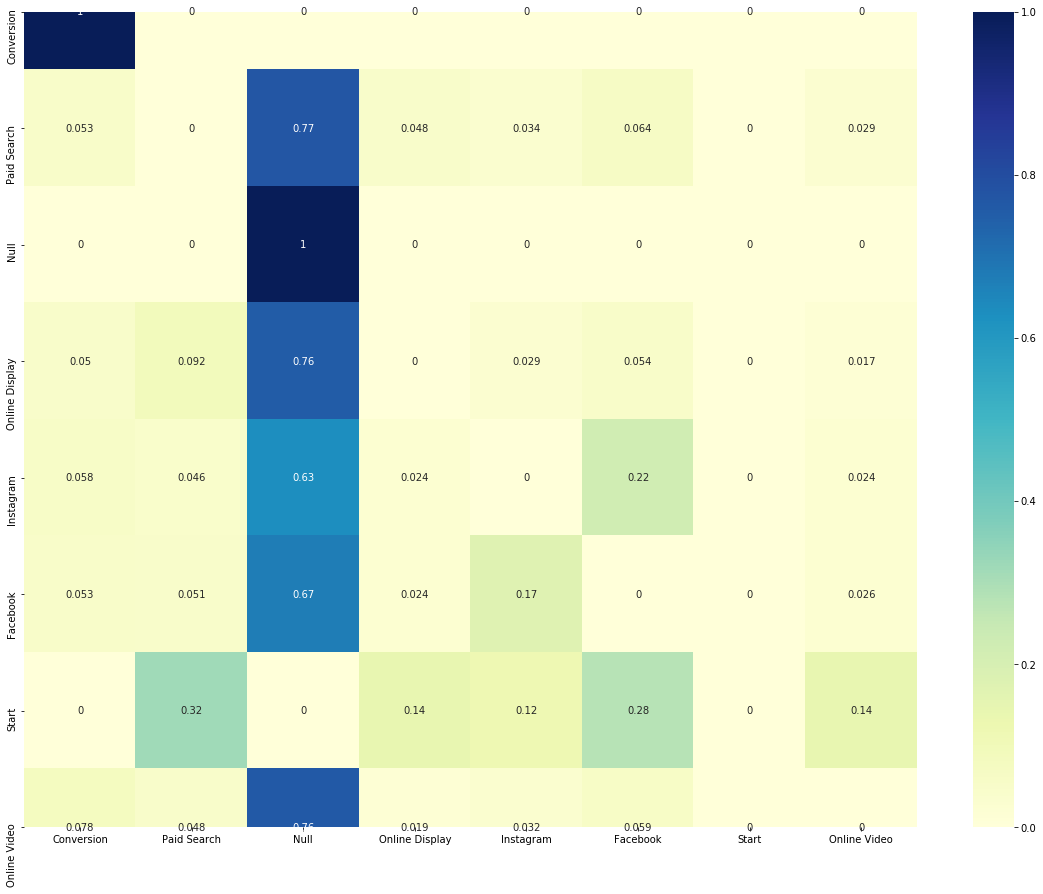

In [14]:
plt.subplots(figsize=(20,15))
sns.heatmap(trans_matrix, cmap="YlGnBu", annot = True)
plt.show()

We can now iteratively go through each of our channels and assess the impact it would have on overall conversion if we were to remove a channel from our state-space. We’ll do this and add the resulting removal effects to an output dictionary:

In [15]:
trans_matrix

,Conversion,Paid Search,Null,Online Display,Instagram,Facebook,Start,Online Video
Conversion,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Paid Search,0.053309,0.000000,0.770779,0.048053,0.034196,0.064442,0.0,0.029221
Null,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
Online Display,0.050324,0.092386,0.756643,0.000000,0.029363,0.053986,0.0,0.017299
Instagram,0.057979,0.045809,0.629786,0.023531,0.000000,0.218777,0.0,0.024118
Facebook,0.053220,0.050655,0.673123,0.024352,0.173072,0.000000,0.0,0.025577
Start,0.000000,0.317399,0.000000,0.142644,0.119188,0.278408,0.0,0.142361
Online Video,0.078146,0.047947,0.763757,0.018920,0.031908,0.059323,0.0,0.000000


In [16]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

The resulting removal effects dictionary can then be used to calculate the Markov Chain attributions for each of our marketing channels:


In [17]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

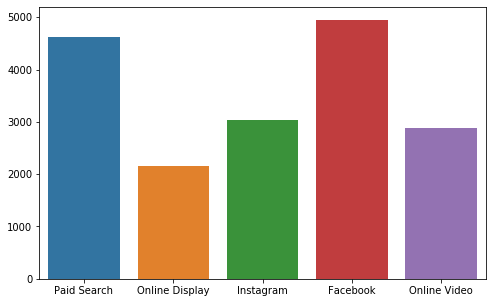

In [18]:
# Plotting the total number of conversions attributed to each channel as per Markov Chains
plt.subplots(figsize=(8,5))
barplot = sns.barplot(list(attributions.keys()), list(attributions.values()))